# PacMan

In [1]:
import numpy as np
from scipy import sparse

In [2]:
from utils import display_maze, display_policy, display_value, display_diff_policy, normalize_sparse, get_moves

## Model

In [3]:
maze = sparse.load_npz('pacman.npz')

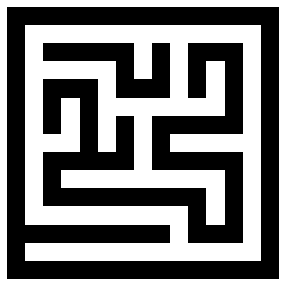

In [4]:
display_maze(maze)

In [5]:
states_target = [(13,1), (11,11)]
states_restart = [[(7,5), (3,7)], [(7,9), (5,3)]]
rewards_target = [100, 100]

In [6]:
class Model():
    """
    Attributes
    ----------
    maze: sparse csr matrix
        Binary map of the maze
    states: list of tuples
        States
    states_target: list of tuples
        Target states (with rewards)
    states_restart: list of list of tuples
        List of restart states (taken uniformly at random)
    rewards_target: list of float
        Rewards of target states
    state_id: dict
        Id of each state
    targets: numpy array
        Ids of target states        
    restarts: list of numpy array
        Ids of restart states
    adjacency: sparse csr matrix
        Matrix of adjacent ids 
    rewards: numpy array
        Reward of each state
    gamma: float (default = 1)
        Discount factor
    """
    def __init__(self, maze, states_target = None, states_restart = None, rewards_target = None, gamma = 1):
        n = maze.nnz
        maze_coo = sparse.coo_matrix(maze)
        states = [(maze_coo.row[i], maze_coo.col[i]) for i in range(n)]

        if states_target is None:
            states_target = [np.random.choice(states)]
        if states_restart is None:
            states_restart = [[np.random.choice(list(set(states) - set(s)), size = 2)] for s in states_target]
        if rewards_target is None:
            rewards_target = [np.random.choice(100) for s in states_target]

        state_id = {s:i for i, s in enumerate(states)}

        targets = np.array([state_id[s] for s in states_target])
        restarts = []
        for states_ in states_restart:
            restarts.append(np.array([state_id[s] for s in states_]))

        row = []
        col = []
        for (i,j) in state_id:
            if (i + 1, j) in state_id:
                row.append(state_id[(i, j)])
                col.append(state_id[(i + 1, j)])
            if (i, j + 1) in state_id:
                row.append(state_id[(i, j)])
                col.append(state_id[(i, j + 1)])
        adjacency = sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n))   
        
        rewards = -np.ones(n)
        rewards[targets] += rewards_target
        
        self.maze = maze
        self.states = states
        self.states_target = states_target
        self.states_restart = states_restart
        self.rewards_target = rewards_target
        self.state_id = state_id
        self.targets = targets
        self.restarts = restarts
        self.adjacency = adjacency + adjacency.T
        self.rewards = rewards
        self.gamma = 1

In [7]:
model = Model(maze, states_target, states_restart, rewards_target)

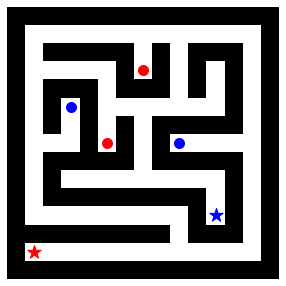

In [8]:
display_maze(model.maze, states_target = model.states_target, states_restart = model.states_restart)

A policy is defined as a sparse transition matrix between states.

In [9]:
def get_transition(policy, model):
    transition = sparse.lil_matrix(policy)
    # no action in target states
    targets = model.targets
    restarts = model.restarts
    for k in range(len(targets)):
        transition[targets[k]] = 0
        transition[targets[k], restarts[k]] = 1
    transition = normalize_sparse(sparse.csr_matrix(transition))
    return transition

## Policy Iteration

In [10]:
# random policy
policy = normalize_sparse(model.adjacency)

In [11]:
def evaluate_policy(policy, V = None, model = model, n_iter_eval = 1000):
    """Evaluate a policy by iterations, starting from V"""
    rewards = model.rewards
    gamma = model.gamma
    transition = get_transition(policy, model)
    if V is None:
        V = np.zeros_like(rewards)
    for t in range(n_iter_eval):
        V = transition.dot(rewards + gamma * V)
    return V

In [12]:
def get_policy_from_value(V, model = model):
    """Get the greedy policy associated with V"""
    n = len(model.states)
    rewards = model.rewards
    gamma = model.gamma
    row = []
    col = []
    for i in range(n):
        indices = model.adjacency[i].indices
        values = (rewards + gamma * V)[indices]
        j = indices[np.argmax(values)]
        row.append(i)
        col.append(j)
    policy = normalize_sparse(sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n)))
    return policy    

In [13]:
def iterate_policy(policy, model = model, n_iter_max = 100, n_iter_eval = 1000, verbose = True, display = False):
    """Get the optimal policy by policy iteration"""
    V = None
    policy_prev = sparse.csr_matrix(policy.shape)
    t = 0
    while (policy - policy_prev).nnz and t < n_iter_max:
        if display:
            display_diff_policy(model.maze, get_moves(policy, model), get_moves(policy_prev, model))
        V = evaluate_policy(policy, V, model, n_iter_eval)
        policy_prev = policy.copy()
        policy = get_policy_from_value(V, model)
        t += 1
    if verbose:
        print("Number of iterations =", t - 1)
    return policy

In [14]:
policy = iterate_policy(policy)

Number of iterations = 3


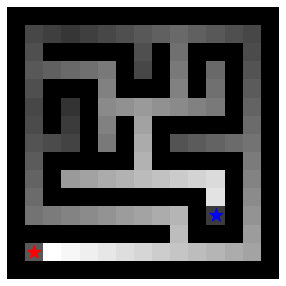

In [15]:
display_value(model.maze, V = evaluate_policy(policy), states_target = model.states_target)

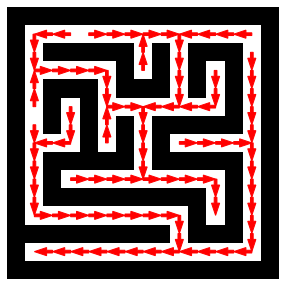

In [16]:
moves = get_moves(policy, model)
display_policy(model.maze, moves)

## Value Iteration

In [19]:
# initial values
V = np.zeros(len(model.states))

In [24]:
def iterate_value(V, model = model, n_iter = 1000, verbose = True):
    """Get the optimal policy by value iteration"""
    policy = get_policy_from_value(V, model)
    for t in range(n_iter):
        V = evaluate_policy(policy, V, model, 1)
        policy = get_policy_from_value(V, model)
    return policy

In [25]:
policy = iterate_value(V)

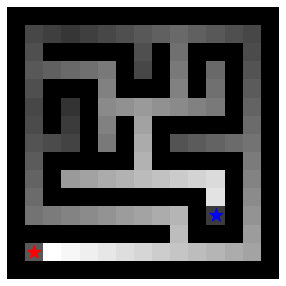

In [26]:
display_value(model.maze, V = evaluate_policy(policy), states_target = model.states_target)

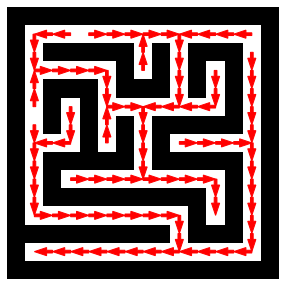

In [27]:
moves = get_moves(policy, model)
display_policy(model.maze, moves)

## SARSA

In [77]:
n_iter = 10000

In [78]:
# initial values of Q
policy = normalize_sparse(model.adjacency)
Q = get_transition(policy, model)
Q.data = np.zeros_like(Q.data)

In [79]:
# action is identified with new state (after move) except for restarts (no action)

def sarsa(Q, model = model, alpha = 0.1, eps = 0.1, n_iter = 100):
    targets = model.targets
    rewards = model.rewards
    gamma = model.gamma
    # random state (not in targets)
    state = np.random.choice(np.setdiff1d(np.arange(len(model.states)), targets))
    # random action
    action = np.random.choice(Q[state].indices)
    new_state = action
    for t in range(n_iter):
        state_prev = state
        action_prev = action
        state = new_state
        if state in targets:
            action = np.min(Q[state].indices)
            new_state = np.random.choice(Q[state].indices)
        else:
            best_action = Q[state].indices[np.argmax(Q[state].data)]
            if np.random.random() < eps:
                action = np.random.choice(Q[state].indices)
            else:
                action = best_action
            new_state = action
        Q[state_prev, action_prev] = (1 - alpha) *  Q[state_prev, action_prev] + alpha * (rewards[action_prev] + gamma * Q[state, action])
    return Q

In [80]:
def get_policy_from_action_value(Q, model = model):
    """Get the greedy policy associated with Q"""
    n = len(model.states)
    row = []
    col = []
    for i in range(n):
        indices = Q[i].indices
        j = indices[np.argmax(Q[i].data)]
        row.append(i)
        col.append(j)
    policy = normalize_sparse(sparse.csr_matrix((np.ones_like(row), (row, col)), shape = (n, n)))
    return policy    

In [81]:
Q = sarsa(Q, n_iter = n_iter)

In [82]:
policy = get_policy_from_action_value(Q)

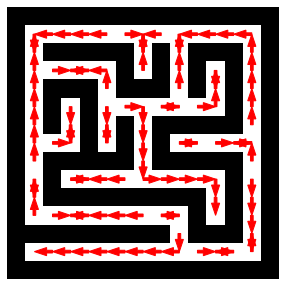

In [83]:
moves = get_moves(policy, model)
display_policy(model.maze, moves)

## Q-learning

In [72]:
# initial values of Q
policy = normalize_sparse(model.adjacency)
Q = get_transition(policy, model)
Q.data = np.zeros_like(Q.data)

In [73]:
# action is identified with new state (after move) except for restarts (no action)

def qlearning(Q, model = model, alpha = 0.1, eps = 0.1, n_iter = 100):
    targets = model.targets
    rewards = model.rewards
    gamma = model.gamma
    # random state (not in targets)
    state = np.random.choice(np.setdiff1d(np.arange(len(model.states)), model.targets))
    # random action
    action = np.random.choice(Q[state].indices)
    new_state = action
    for t in range(n_iter):
        state_prev = state
        action_prev = action
        state = new_state
        if state in targets:
            action = np.min(Q[state].indices)
            new_state = np.random.choice(Q[state].indices)
        else:
            best_action = Q[state].indices[np.argmax(Q[state].data)]
            if np.random.random() < eps:
                action = np.random.choice(Q[state].indices)
            else:
                action = best_action
            new_state = action
        Q[state_prev, action_prev] = (1 - alpha) *  Q[state_prev, action_prev] + alpha * (rewards[action_prev] + gamma * Q[state, best_action])
    return Q

In [74]:
Q = qlearning(Q, n_iter = n_iter)

In [75]:
policy = get_policy_from_action_value(Q)

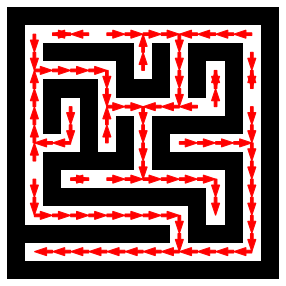

In [76]:
moves = get_moves(policy, model)
display_policy(model.maze, moves)